In [1]:
import os

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

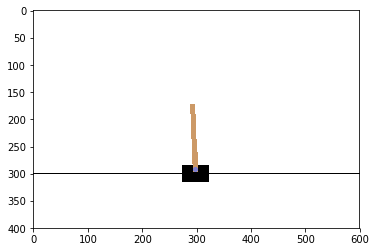

In [3]:
env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [4]:
import tensorflow as tf
import tensorflow.contrib.layers as tflayers  # Let's make TF simple again

/home/artem/.conda/envs/teaching/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
current_states = tf.placeholder(shape=[None, 4], dtype=tf.float32)
actions = tf.placeholder(shape=None, dtype=tf.int32)
rewards = tf.placeholder(shape=None, dtype=tf.float32)
next_states = tf.placeholder(shape=[None, 4], dtype=tf.float32)
# is_end should be bool vector
is_end = tf.placeholder(shape=None, dtype=tf.bool)

In [6]:
def network(l_states, scope=None, reuse=False):
    assert l_states.get_shape().as_list() == list((None,)+state_dim)
    with tf.variable_scope(scope or "network") as scope:
        if reuse:
            scope.reuse_variables()
        
        w1 = tf.get_variable(name="w1", shape=(4, 20))
        b1 = tf.get_variable(name="b1", shape=(20))
        w2 = tf.get_variable(name="w2", shape=(20, 2))
        b2 = tf.get_variable(name="b2", shape=(2))
        
        h1 = tf.nn.relu(tf.matmul(l_states, w1) + b1)
        l_qvalues = tf.matmul(h1, w2) + b2
        
        return l_qvalues

In [8]:
def network(l_states, scope=None, reuse=False):
    assert l_states.get_shape().as_list() == list((None,)+state_dim)
    with tf.variable_scope(scope or "network") as scope:
        if reuse:
            scope.reuse_variables()
        
        w1 = tf.get_variable(name="w1", shape=(4, 2))
        b1 = tf.get_variable(name="b1", shape=(2))
        
        l_qvalues = tf.matmul(l_states, w1) + b1
        
        return l_qvalues

In [7]:
#get q-values for ALL actions in current_states
predicted_qvalues = network(current_states)
inds = tf.stack([tf.range(0, 1), actions], axis=1)
predicted_qvalues_for_actions = tf.gather_nd(predicted_qvalues, inds)

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [8]:
predicted_next_qvalues = network(next_states, reuse=True)
gamma = 0.99
target_qvalues_for_actions = rewards + gamma*tf.reduce_max(predicted_next_qvalues, axis=1) 
target_qvalues_for_actions = tf.where(
    is_end, 
    tf.zeros_like(target_qvalues_for_actions),
    target_qvalues_for_actions)

In [9]:
loss = tf.reduce_mean(tf.square(predicted_qvalues_for_actions - target_qvalues_for_actions))

In [10]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(
    loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="network"))

### Playing the game

In [11]:
# Tensorflow feature - session
sess = tf.InteractiveSession()
# Tensorflow feature 2 - variables initializer
sess.run(tf.global_variables_initializer())
# You can check all your valiables by:
[v.name for v in tf.trainable_variables()]
# they should all starts with "network"

['network/w1:0', 'network/b1:0', 'network/w2:0', 'network/b2:0']

In [12]:
import random

In [13]:
inial_epsilon = epsilon = 0.5
final_epsilon = 0.01
n_epochs = 1000



possible_actions = [0, 1]

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    total_loss = 0
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = sess.run(
            predicted_qvalues, 
            feed_dict={current_states:np.array([s])})[0]
        
        if random.random() < epsilon: 
            a = random.choice([0, 1])
        else: 
            best_inds = np.argwhere(q_values == np.max(q_values))
            best_inds = best_inds.flatten().tolist()
            best_ind = random.choice(best_inds)
            a = possible_actions[best_ind]
            
        
        new_s, r, done, info = env.step(a)

        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        curr_loss, _, predicted_next_qvalues_val  = sess.run([loss, train_step, predicted_next_qvalues], feed_dict={actions: np.array([a]), 
                                                             rewards: np.array([r]), 
                                                             next_states: np.array([new_s]), 
                                                             current_states: np.array([s]), 
                                                             is_end: np.array([done], dtype=bool)})

        total_reward += r
        total_loss += curr_loss
        
        s = new_s
        if done: 
            break
            
    return total_reward, total_loss/float(t), t

In [14]:
from tqdm import trange
tr = trange(
    n_epochs,
    desc="mean reward = {:.3f}\tepsilon = {:.3f}\tloss = {:.3f}\tsteps = {:.3f}".format(0.0, 0.0, 0.0, 0.0),
    leave=True)

epsilon = 0.5
for i in tr:
    
    sessions = [generate_session() for _ in range(100)] #generate new sessions
    session_rewards, session_loss, session_steps = map(np.array, zip(*sessions))
    
    #for v in tf.trainable_variables():
    #    print(sess.run(v))
    #print(session_rewards)
    #print(session_loss)
    #print(session_steps)
    
    epsilon -= (inial_epsilon - final_epsilon) / float(n_epochs)
    
    tr.set_description("mean reward = {:.3f}\tepsilon = {:.3f}\tloss = {:.3f}\tsteps = {:.3f}".format(
        np.mean(session_rewards), epsilon, np.mean(session_loss), np.mean(session_steps)))
    #print(session_rewards)

    if np.mean(session_rewards) >= 300:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"

mean reward = 96.430	epsilon = 0.138	loss = 0.752	steps = 95.430:  74%|███████▍  | 739/1000 [57:49<20:25,  4.69s/it]  

KeyboardInterrupt: 

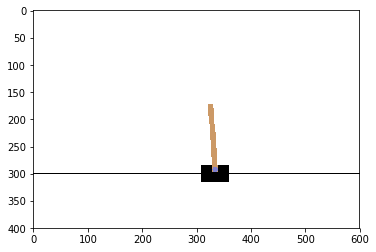

In [18]:
s = env.reset()


for i in range(300):
    plt.imshow(env.render("rgb_array"))
    q_values = sess.run(predicted_qvalues, 
                        feed_dict={current_states:np.array([s])})[0]
    
    best_inds = np.argwhere(q_values == np.max(q_values))
    best_inds = best_inds.flatten().tolist()
    best_ind = random.choice(best_inds)
    a = possible_actions[best_ind]
    
    new_s, r, done, info = env.step(a)
    
    s = new_s
    

In [19]:
import this


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
